[![Open In Colab](./images/colab-badge.png)](https://colab.research.google.com/github/abrsvn/pyactr-book/blob/master/notebooks/28_subsymbolic_dec_mem_ebbinghaus_data_log_transform.ipynb)

# Modeling linguistic performance

The goal of ACT-R is to provide accurate cognitive models of learning and performance, as well as accurate neural mappings of cognitive activities.

- in this notebook, we start introducing the 'subsymbolic' declarative memory components of ACT-R
- these are essential to modeling performance, i.e., actual human behavior in experimental tasks
- we then build end-to-end models for a variety of psycholinguistic tasks, e.g., list recall, lexical decision, (self-paced) reading, and evaluate how closely these models fit the actual data
- the models we build are end-to-end in the sense that they include
    - explicit linguistic analyses that are primarily encoded in the production rules (i.e., in procedural memory)
    - a realistic model of declarative memory
    - simple, but reasonably realistic, vision and motor modules
- we won't discuss the 'subsymbolic' components associated with procedural memory (production utilities: learning them and using them in production selection)

When studying performance, we are usually interested in two measures:

- what response people choose given some stimulus
- how much time it takes them to make that choice, known as reaction time (RT)

In linguistics, the first measure often appears as the ''Accept--Reject'' response when people judge the grammatical or interpretational status of a sentence or a discourse.
- other types of experimental tasks also fit here, for example, responses in forced-choice tasks, lexical decision tasks etc.

The second measure often encodes how much time it takes to choose a particular response.
- but other options also exist, e.g., how much time it takes to shift eye gaze, to move a mouse etc.

In this notebook and the following ones, we introduce the components of ACT-R that enable us to make good predictions with respect to both kinds of measures with a cognitively plausible mechanism (we focus exclusively on declarative memory).

## The power law of forgetting

The main idea behind the ACT-R declarative memory architecture is that

> ''human memory is behaving optimally with respect to the pattern of past information presentation. Each item in memory has had some history of past use. For instance, our memory for one person's name may not have been used in the past month but might have been used five times in the month previous to that. What is the probability that the memory will be needed (used) during the conceived current day? Memory would be behaving optimally if it made this memory less available than memories that were more likely to be used but made it more available than less likely memories.'' (Anderson, John R., and Lael J. Schooler. 1991. Reflections of the environment in memory.
_Psychological Science_ 2, p. 396)

The availability of a specific chunk stored in declarative memory, i.e., its **activation**, is a function of the past use of that memory chunk (among other things; more about other factors later).

- chunk activation determines both the probability that it will be successfully retrieved and its retrieval time/latency

To see how this is actually formalized in ACT-R, let's examine the well-known retention data presented in Chapter 7 of **Ebbinghaus, Hermann. 1913. _Memory: A contribution to experimental psychology_. New
York: Teachers College, Columbia University**. (http://psychclassics.yorku.ca/Ebbinghaus/index.htm).

The stimulus materials used by Ebbinghaus consisted of nonsense CVC syllables, about $2300$ in number.

- they were mixed together and then syllables were randomly selected to construct series of different lengths
- the method used was 'learning to criterion':
    - the subject repeats the material as many times as necessary to reach a prespecified level of accuracy (e.g., one perfect reproduction)
- the retention measure was 'savings':
    - subtracting the number of repetitions required to relearn material to criterion at a later point from the number of repetitions originally required to learn the material to criterion
    - let's say that initially, we need 10 repetitions to learn a series of CVC syllables to criterion
    - 1 day later, we need only 7 repetitions to learn that same series to criterion
    - the savings are the proportion $\frac{10-7}{10} = 0.3$ of the original number of repetitions that we 'saved', i.e., we didn't have to do again
    - the savings are expressed as percentages, not as proportions; in our example, our savings are $30$ (as in $30\%$)

In [1]:
# loading the data
import pandas as pd

url = 'https://github.com/abrsvn/pyactr-book/blob/master/data/ebbinghaus_retention_data.csv?raw=true'
ebbinghaus_data = pd.read_csv(url)
ebbinghaus_data

,delay_in_hours,percent_savings
0,0.33,58.2
1,1.00,44.2
2,8.80,35.8
3,24.00,33.7
4,48.00,27.8
5,144.00,25.4
6,744.00,21.1


- there are 7 data points / observations (7 rows, numbered 0 through 6)
- the first column in the data is the independent variable (time):
    - it records the delay in hours that the relearning of the syllable series took place relative to the initial learning-to-criterion time
- the second column is the dependent variable (activation in memory):
    - it records the percent savings observed for the corresponding delay in hours, i.e., the (proportional) reduction in repetitions of the target series of syllables needed to relearn it to criterion

For completeness, let's take a look at the summary of the Ebbinghaus data:

- this gives us the total number of observations (7)
- the means for the delay in hours and savings percentages ($138.59$ and $35.17$ respectively)
- the standard deviation (a measure of dispersion) etc.

In [2]:
ebbinghaus_data.describe()

,delay_in_hours,percent_savings
count,7.00000,7.000000
mean,138.59000,35.171429
std,271.65549,12.663690
min,0.33000,21.100000
25%,4.90000,26.600000
50%,24.00000,33.700000
75%,96.00000,40.000000
max,744.00000,58.200000


A much better way to develop an intuitive understanding of this data is to plot it. Below, we load the visualization (plotting) libraries ```matplotlib``` and ```seaborn```, and plot the data in 3 different ways.

In [3]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 400
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns

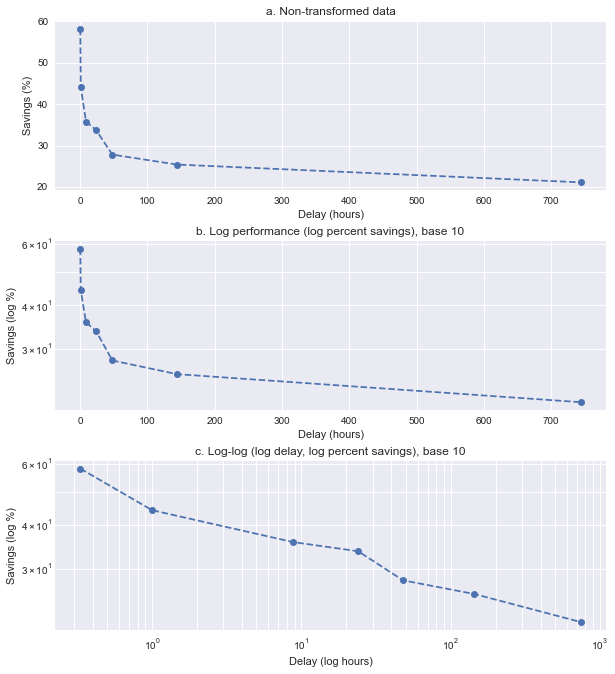

In [4]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=1, nrows=3)
fig.set_size_inches(8.5, 9.3)

# plot 1
ax1.plot(ebbinghaus_data['delay_in_hours'],
         ebbinghaus_data['percent_savings'],
         marker='o', linestyle='--')
ax1.set_title('a. Non-transformed data')
ax1.set_xlabel('Delay (hours)')
ax1.set_ylabel('Savings (%)')

# plot 2
ax2.plot(ebbinghaus_data['delay_in_hours'],
        ebbinghaus_data['percent_savings'],
        marker='o', linestyle='--')
ax2.set_title('b. Log performance (log percent savings), base 10')
ax2.set_xlabel('Delay (hours)')
ax2.set_ylabel('Savings (log %)')
ax2.set_yscale('log', base=10)
ax2.grid(b=True, which='minor', color='w', linewidth=1.0)

# plot 3
ax3.plot(ebbinghaus_data['delay_in_hours'],
        ebbinghaus_data['percent_savings'],
        marker='o', linestyle='--')
ax3.set_title('c. Log-log (log delay, log percent savings), base 10')
ax3.set_xlabel('Delay (log hours)')
ax3.set_xscale('log', base=10)
ax3.set_ylabel('Savings (log %)')
ax3.set_yscale('log', base=10)
ax3.grid(b=True, which='minor', color='w', linewidth=1.0)
# clean up
plt.tight_layout(pad=0.5, w_pad=0.2, h_pad=0.7)

The three panels in the figure above plot the retention data:

- in its non-transformed form (panel a)
- with a logarithmically compressed $y$ axis (panel b: we plot log percent savings)
- with both axes logarithmically compressed (panel c)

We see that a linear relation emerges in the final log-log plot, which indicates that forgetting (decay of chunk activation in declarative memory) has a particular functional form -- to which we now turn.

- the log tick marks in the plots are in base 10 for readability, although we will always work with the natural logarithm, i.e., log base $e$

The forgetting curve in plot (a) is sometimes taken to reflect an underlying negative exponential forgetting function of the form:

- $P = \alpha e^{-\beta T}$, where:
   - $P$ is the memory-related performance measure (percent savings in the Ebbinghaus data),
   - $T$ is the time delay since presentation (since initial learning to criterion in our case), and
   - $\alpha, \beta$ are the free parameters of the model, to be fit to the data.

But this predicts that performance should be a linear function of time if we log-transform the performance $P$:

- $\log(P) = \log(\alpha) - \beta T$, i.e., a linear function of time $T$ with intercept $\log(\alpha)$ and negative slope $-\beta$

One way to intuitively think about logarithmic transformation / logarithmic compression is to think about a series of evenly / linearly spaced trees that you can see on the side of a long straight road as you look up the road:

- the distances between the trees appear smaller and smaller as the trees are further and further away, until the trees basically become one tree as the gaze approaches the horizon

This is shown in the figure below:

![Log transformation in visual perception](./figures/avenue_modified.jpg)

(Source: [pixabay](https://pixabay.com/en/avenue-tree-trees-away-road-196335/), retrieved April 10, 2017)

- the further away two trees are from us, the distance between them appears smaller and smaller
- similarly, the larger the numbers are, the difference between the numbers is compressed further and further: the difference between $4$ and $2$ is compressed much less than the difference between $14$ and $12$ under the log transform
    - equivalently, the larger a number is, the higher its compression under the log transform
    - this is shown on lines 3-4 below, as well as in the plot of the log transform (for $x\geq 1$) below

In [5]:
import numpy as np

np.log(4) - np.log(2)
np.log(14) - np.log(12)

0.15415067982725805

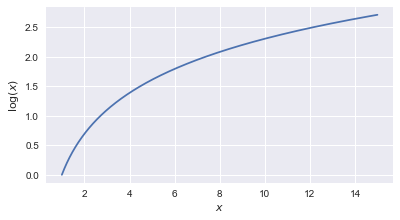

In [6]:
fig, ax = plt.subplots(ncols=1, nrows=1)
fig.set_size_inches(5.5, 3)
x = np.arange(1, 15, 0.01)
ax.plot(x, np.log(x), linestyle='-')
#ax.set_xlim(left=1)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$\log(x)$')
plt.tight_layout(pad=0.5, w_pad=0.2, h_pad=0.7)

Whenever we use logarithm _simpliciter_ without explicitly specifying the base, we always mean the natural logarithm function, i.e., log base $e$.

- we will therefore abbreviate the natural logarithm of a number $x$ simply as $\log(x)$ or, dropping parentheses, $\log x$ (rather than $\mbox{ln}\,x$ or $\log_{e} x$)